Trabalho de Referência  
https://python.plainenglish.io/creating-machine-learning-models-to-predict-football-game-outcomes-70b6bf02885c  
https://github.com/RishiSankhe/FbMatchPredictor

Importando Pacotes

In [15]:
# !pip install -r requirements.txt

In [16]:
import pandas as pd
import numpy as np
from joblib import dump
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import  MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

Configurações do codigo

In [17]:
#Exibir totas as colunas no pandas
pd.set_option('display.max_columns', None)
season = 2023

### Importando a Base Tratada

In [18]:
data = pd.read_excel(f'data/trusted/base_brasileirao_{season}.xlsx')
data.head()

,fixture.id,fixture.date,league.round,teams.home.id,teams.home.name,teams.home.winner,teams.away.id,teams.away.name,teams.away.winner,score.halftime.home,score.halftime.away,score.fulltime.home,score.fulltime.away,result,result.team,HTR,home.pf.drw,home.pf.win,home.pf.los,away.pf.drw,away.pf.win,away.pf.los,home.BLPS,home.BSH,home.CK,home.EXPGL,home.FOU,home.GKSV,home.OFSD,home.PAS%,home.PASAC,home.RCD,home.SHFG,home.SHIN,home.SHOG,home.SHOU,home.TPAS,home.TSH,home.YCD,away.BLPS,away.BSH,away.CK,away.EXPGL,away.FOU,away.GKSV,away.OFSD,away.PAS%,away.PASAC,away.RCD,away.SHFG,away.SHIN,away.SHOG,away.SHOU,away.TPAS,away.TSH,away.YCD
0,1005649,2023-04-16,1,127,Flamengo,True,147,Coritiba,False,1,0,3,0,1,Flamengo,1,NaN,NaN,NaN,NaN,NaN,NaN,59,3,6,1.37,20,3,1,89,480,0,5,5,7,10,542,15,3,41,5,3,0.36,17,4,2,85,322,0,2,3,3,7,379,10,3
1,1005650,2023-04-15,1,120,Botafogo,True,126,Sao Paulo,False,1,1,2,1,1,Botafogo,0,NaN,NaN,NaN,NaN,NaN,NaN,32,4,3,0.84,20,7,2,78,229,0,5,6,3,6,293,12,3,68,2,7,1.86,13,1,1,89,574,0,6,11,8,5,646,16,2
2,1005651,2023-04-15,1,121,Palmeiras,True,1193,Cuiaba,False,1,1,2,1,1,Palmeiras,0,NaN,NaN,NaN,NaN,NaN,NaN,52,5,4,2.69,23,3,3,84,382,0,7,10,5,7,455,17,2,48,2,4,0.67,12,3,2,79,337,1,6,6,4,6,426,12,5
3,1005652,2023-04-16,1,131,Corinthians,True,135,Cruzeiro,False,0,0,2,1,1,Corinthians,0,NaN,NaN,NaN,NaN,NaN,NaN,42,1,7,1.54,14,1,4,78,316,0,4,6,7,6,406,12,4,58,3,4,0.49,12,5,3,85,489,0,3,4,2,4,572,8,2
4,1005653,2023-04-15,1,794,RB Bragantino,True,118,Bahia,False,0,1,2,1,1,RB Bragantino,2,NaN,NaN,NaN,NaN,NaN,NaN,56,2,4,2.11,20,2,2,78,339,0,4,6,7,7,436,13,3,44,1,7,0.65,13,5,3,72,248,0,5,5,3,4,343,9,1


In [19]:
matches = data.shape[0]
columns = data.shape[1]

home_win = len(data[data['result'] == 1])
away_win = len(data[data['result'] == 2])
draw_win = len(data[data['result'] == 0])

print('Qtd Partidas:', matches)
print('Qtd Colunas:', columns)
print('Vit Mandante:', home_win)
print('Vit Visitante:', away_win)
print('Empate:', draw_win)
print('% Mandante:', round(home_win/matches*100,2))
print('% Visitante:', round(away_win/matches*100,2))
print('% Empate:', round(draw_win/matches*100,2))

Qtd Partidas: 380
Qtd Colunas: 56
Vit Mandante: 178
Vit Visitante: 104
Empate: 98
% Mandante: 46.84
% Visitante: 27.37
% Empate: 25.79


In [20]:
data.isna().sum()

fixture.id              0
fixture.date            0
league.round            0
teams.home.id           0
teams.home.name         0
teams.home.winner       0
teams.away.id           0
teams.away.name         0
teams.away.winner       0
score.halftime.home     0
score.halftime.away     0
score.fulltime.home     0
score.fulltime.away     0
result                  0
result.team             0
HTR                     0
home.pf.drw            20
home.pf.win            20
home.pf.los            20
away.pf.drw            20
away.pf.win            20
away.pf.los            20
home.BLPS               0
home.BSH                0
home.CK                 0
home.EXPGL              0
home.FOU                0
home.GKSV               0
home.OFSD               0
home.PAS%               0
home.PASAC              0
home.RCD                0
home.SHFG               0
home.SHIN               0
home.SHOG               0
home.SHOU               0
home.TPAS               0
home.TSH                0
home.YCD    

In [21]:
data = data.dropna()

### Train and Test

In [22]:

def generate_df_feature_label(df:pd.DataFrame):

    _list = ['teams.home.id', 'score.halftime.home', 'home.pf.drw', 'home.pf.win', 'home.pf.los',
             'home.BLPS', 'home.BSH', 'home.CK', 'home.EXPGL', 'home.GKSV',
             'home.OFSD', 'home.RCD', 'home.SHFG', 'home.SHIN',
             'home.SHOG', 'home.SHOU'
          ]
    list_features = _list + [x.replace('home', 'away') for x in _list] + ['HTR']

    features = df[list_features]
    labels = df['result']

    return features, labels

In [23]:
df_train = data[data['league.round'] <= 28]
df_test = data[data['league.round'] > 28]

X_train, y_train = generate_df_feature_label(df_train)
X_test, y_test = generate_df_feature_label(df_test)

X_train_norm = MinMaxScaler().fit(X_train).transform(X_train)
X_test_norm = MinMaxScaler().fit(X_test).transform(X_test)

print( len(X_train), len(y_train) )
print( len(X_test), len(y_test) )

260 260
100 100


### Baseline
Comparando resultado do intervalo com o do final do jogo

In [24]:
y_pred_train = X_train['HTR']
y_pred_test = X_test['HTR']


accuracy_baseline_test = round(accuracy_score(y_pred_test, y_test),3)
print('Accuracy on Train data: ', round(accuracy_score(y_pred_train, y_train), 3))
print('Accuracy on Test data: ', accuracy_baseline_test)

Accuracy on Train data:  0.585
Accuracy on Test data:  0.6


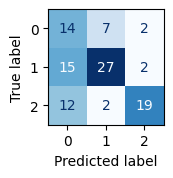

In [25]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test))
cm_display.plot(ax=ax, colorbar=False, cmap='Blues')

In [26]:
#Jogando Fora, perdendo no intervalo e virou o jogo
df_test[(df_test['HTR']==2) & (df_test['result']==1)]

,fixture.id,fixture.date,league.round,teams.home.id,teams.home.name,teams.home.winner,teams.away.id,teams.away.name,teams.away.winner,score.halftime.home,score.halftime.away,score.fulltime.home,score.fulltime.away,result,result.team,HTR,home.pf.drw,home.pf.win,home.pf.los,away.pf.drw,away.pf.win,away.pf.los,home.BLPS,home.BSH,home.CK,home.EXPGL,home.FOU,home.GKSV,home.OFSD,home.PAS%,home.PASAC,home.RCD,home.SHFG,home.SHIN,home.SHOG,home.SHOU,home.TPAS,home.TSH,home.YCD,away.BLPS,away.BSH,away.CK,away.EXPGL,away.FOU,away.GKSV,away.OFSD,away.PAS%,away.PASAC,away.RCD,away.SHFG,away.SHIN,away.SHOG,away.SHOU,away.TPAS,away.TSH,away.YCD
286,1005935,2023-10-25,29,130,Gremio,True,127,Flamengo,False,0,1,3,2,1,Gremio,2,0.0,0.67,0.33,0.67,0.33,0.00,37,4,6,1.01,14,2,0,79,279,0,3,6,4,5,352,11,3,63,0,1,1.09,16,1,0,88,554,0,4,7,4,1,628,8,4
356,1006005,2023-11-30,36,130,Gremio,True,151,Goias,False,0,1,2,1,1,Gremio,2,0.0,0.67,0.33,0.00,0.33,0.67,50,5,6,1.07,16,5,0,78,339,0,1,7,7,6,432,13,3,50,2,3,0.68,15,5,1,78,341,0,6,7,6,7,436,14,2


In [27]:
#Jogando em Casa, ganhando no intervalo e tomou a virada
df_test[(df_test['HTR']==1) & (df_test['result']==2)]

,fixture.id,fixture.date,league.round,teams.home.id,teams.home.name,teams.home.winner,teams.away.id,teams.away.name,teams.away.winner,score.halftime.home,score.halftime.away,score.fulltime.home,score.fulltime.away,result,result.team,HTR,home.pf.drw,home.pf.win,home.pf.los,away.pf.drw,away.pf.win,away.pf.los,home.BLPS,home.BSH,home.CK,home.EXPGL,home.FOU,home.GKSV,home.OFSD,home.PAS%,home.PASAC,home.RCD,home.SHFG,home.SHIN,home.SHOG,home.SHOU,home.TPAS,home.TSH,home.YCD,away.BLPS,away.BSH,away.CK,away.EXPGL,away.FOU,away.GKSV,away.OFSD,away.PAS%,away.PASAC,away.RCD,away.SHFG,away.SHIN,away.SHOG,away.SHOU,away.TPAS,away.TSH,away.YCD
301,1005950,2023-11-01,31,120,Botafogo,False,121,Palmeiras,True,3,0,3,4,2,Palmeiras,1,0.67,0.0,0.33,0.0,0.33,0.67,40,3,2,2.95,12,2,0,81,243,1,7,11,8,7,300,18,6,60,4,6,1.67,13,5,3,89,385,0,5,9,6,6,433,15,5
321,1005970,2023-11-09,33,120,Botafogo,False,130,Gremio,True,2,1,3,4,2,Gremio,1,0.33,0.0,0.67,0.0,0.67,0.33,51,3,2,1.45,8,2,0,77,300,0,4,8,5,4,392,12,1,49,3,6,2.23,17,2,0,73,276,0,4,11,6,2,377,13,1


### Modelo Regressão Logistica

In [28]:
logit = LogisticRegression()
logit.fit(X_train_norm, y_train)

print('Logistic regression accuracy on train set: ', round(logit.score(X_train,y_train),3))
print('Logistic regression accuracy on test set: ', round(logit.score(X_test,y_test),3))

Logistic regression accuracy on train set:  0.258
Logistic regression accuracy on test set:  0.33


c:\Users\BlueShift\miniconda3\envs\infnetSports\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\BlueShift\miniconda3\envs\infnetSports\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [29]:
## Adjusting C parameter
logit_tuned = LogisticRegression(penalty = 'l2', C = 0.000001)
logit_tuned.fit(X_train,y_train)

# storage variables
train_accuracies = []
test_accuracies = []
c_vals = np.logspace(-7, -2.5, num = 100) # Penalty parameters to test

## Hyperparameter tuning for loop
for c_val in c_vals: # For every penalty parameter we're testing

   # Fit model on training data
   logit_tuned = LogisticRegression(penalty = 'l2', C = c_val)
   logit_tuned.fit(X_train, y_train)

   # Store training and test accuracies
   train_accuracies.append(logit_tuned.score(X_train,y_train))
   test_accuracies.append(logit_tuned.score(X_test,y_test))

c:\Users\BlueShift\miniconda3\envs\infnetSports\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\BlueShift\miniconda3\envs\infnetSports\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Maximum test accuracy:  0.62
Value of C that achieves max test accuracy:  0.00285


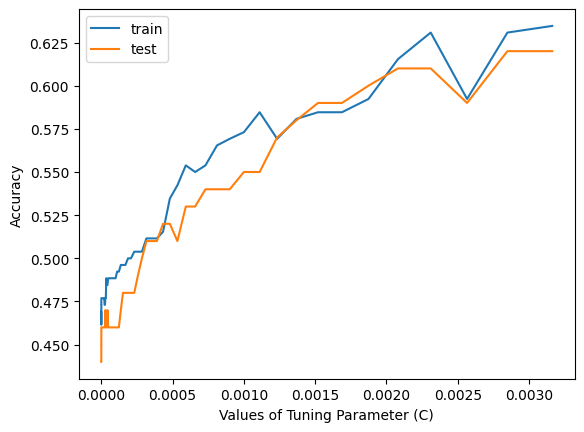

In [30]:
# plot train and test accuracies
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(c_vals, train_accuracies, label = 'train')
ax.plot(c_vals, test_accuracies, label = 'test')
ax.set_xlabel('Values of Tuning Parameter (C)')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'best')


## Determining maximizing C on test set
accuracy_logit_test = round(test_accuracies[np.argmax(test_accuracies)], 3)
print('Maximum test accuracy: ', accuracy_logit_test)
print('Value of C that achieves max test accuracy: ', round(c_vals[np.argmax(test_accuracies)],5))

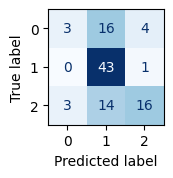

In [31]:
y_pred = logit_tuned.predict(X_test)

fig, ax = plt.subplots(figsize=(1.5,1.5))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
cm_display.plot(ax=ax, colorbar=False, cmap='Blues')

### Modelo Árvore de Decisão

Tree accuracy on train set:  1.0
Tree accuracy on test set:  0.56


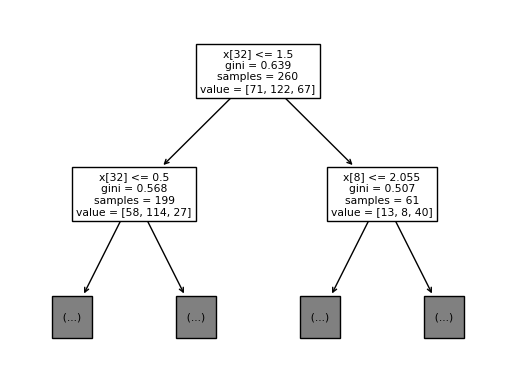

In [32]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

sklearn.tree.plot_tree(tree,max_depth=1)

print('Tree accuracy on train set: ', round(tree.score(X_train,y_train),3))
print('Tree accuracy on test set: ', round(tree.score(X_test,y_test),3))

In [33]:
# storage variables
train_accuracies = []
test_accuracies = []
min_vals = np.linspace(0.001, 1, num = 500) # Penalty parameters to test

## Hyperparameter tuning for loop
for min_val in min_vals: # For every penalty parameter we're testing

   # Fit model on training data
   tree_tuned = DecisionTreeClassifier(min_samples_split = min_val)
   tree_tuned.fit(X_train, y_train)

   # Store training and test accuracies
   train_accuracies.append(tree_tuned.score(X_train,y_train))
   test_accuracies.append(tree_tuned.score(X_test,y_test))

Maximum test accuracy:  0.67
Value of min samples that achieves max test accuracy:  0.32733


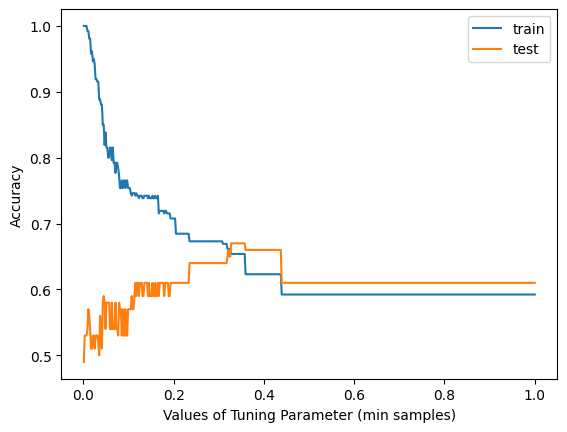

In [34]:
# plot train and test accuracies
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(min_vals, train_accuracies, label = 'train')
ax.plot(min_vals, test_accuracies, label = 'test')
ax.set_xlabel('Values of Tuning Parameter (min samples)')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'best')

accuracy_decision_test = round(test_accuracies[np.argmax(test_accuracies)], 3)
print('Maximum test accuracy: ', accuracy_decision_test)
print('Value of min samples that achieves max test accuracy: ', round(min_vals[np.argmax(test_accuracies)],5))

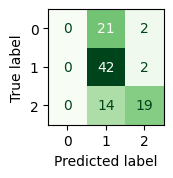

In [35]:
y_pred = tree_tuned.predict(X_test)

fig, ax = plt.subplots(figsize=(1.5,1.5))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
cm_display.plot(ax=ax, colorbar=False, cmap='Greens')

### Modelo Random Forest

In [36]:
forest = RandomForestClassifier()
forest.fit(X_train,y_train)

print('Random forest accuracy on train set: ', round(forest.score(X_train,y_train),3))
print('Random Forest accuracy on test set: ', round(forest.score(X_test,y_test),3))

Random forest accuracy on train set:  1.0
Random Forest accuracy on test set:  0.64


In [37]:
# storage variables
train_accuracies = []
test_accuracies = []
min_vals = np.linspace(0.001, 1, num = 10) # Penalty parameters to test
nTrees = np.arange(1,1000,step=200)

## Hyperparameter tuning for loop
for min_val in min_vals: # For every penalty parameter we're testing
   for nTree in nTrees:
    # Fit model on training data
    forest_tuned = RandomForestClassifier(min_samples_split = min_val, n_estimators = nTree)
    forest_tuned.fit(X_train, y_train)

    # Store training and test accuracies
    train_accuracies.append(forest_tuned.score(X_train,y_train))
    test_accuracies.append(forest_tuned.score(X_test,y_test))

In [38]:
accuracy_forest_test = round(test_accuracies[np.argmax(test_accuracies)], 3)
print('Maximum test accuracy: ', accuracy_forest_test)
print('Value of min samples that achieves max test accuracy: ', round(min_vals[round(np.argmax(test_accuracies)/1000)],5))
print('Value of min trees that achieves max test accuracy: ', round(nTrees[1],5))

Maximum test accuracy:  0.67
Value of min samples that achieves max test accuracy:  0.001
Value of min trees that achieves max test accuracy:  201


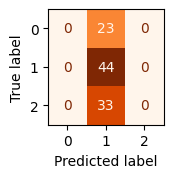

In [39]:
y_pred = forest_tuned.predict(X_test)

fig, ax = plt.subplots(figsize=(1.5,1.5))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
cm_display.plot(ax=ax, colorbar=False, cmap='Oranges')

### Comparação de Resultados

In [40]:
pd.DataFrame({
    'Model' : ['Baseline', 'Regressão Logistica', 'Árvore Decisão', 'Random Forest'],
    'Accuracy' : [accuracy_baseline_test, accuracy_logit_test, accuracy_decision_test, accuracy_forest_test]
    })


,Model,Accuracy
0,Baseline,0.60
1,Regressão Logistica,0.62
2,Árvore Decisão,0.67
3,Random Forest,0.67


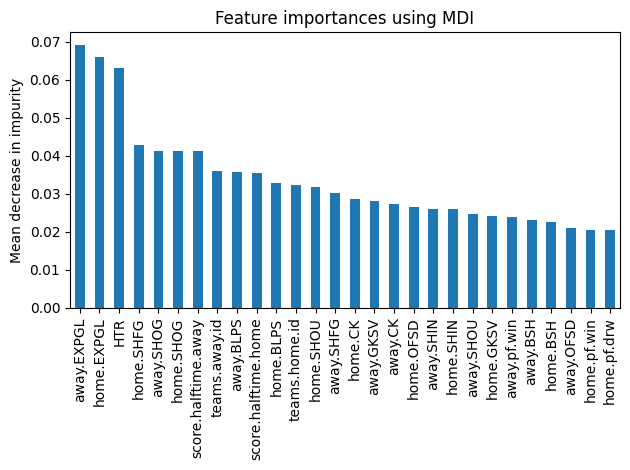

In [41]:
# Get random forest feature importances

importances = forest.feature_importances_
feature_names = X_train.columns

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances[forest_importances > 0.02].sort_values(ascending = False).plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Salvando Modelo 

In [42]:
dump(tree_tuned, f'modelos/modelo_arvore_decisao_brasileirao_{season}.joblib')

['modelos/modelo_arvore_decisao_brasileirao_2023.joblib']